Transformer 是一种革命性的深度学习模型架构，主要用于自然语言处理（NLP）任务。它由Google在2017年的论文《Attention is All You Need》中首次提出。以下是Transformer的核心特点：

1. **自注意力机制（Self-Attention）**：
   - 这是Transformer的核心创新
   - 允许模型在处理每个词时关注输入序列中的所有词
   - 能够捕捉长距离依赖关系

2. **并行计算**：
   - 与RNN不同，Transformer可以并行处理整个序列
   - 大大提高了训练效率

3. **编码器-解码器结构**：
   - 编码器：将输入序列转换为一系列特征表示
   - 解码器：根据编码器的输出生成目标序列

4. **位置编码**：
   - 由于Transformer没有循环结构，需要额外添加位置信息
   - 通过正弦/余弦函数或学习得到的位置编码来实现



Transformer模型可以主要分为以下几个核心部分：

1. **输入部分（Input Processing）**
   - 词嵌入（Word Embedding）
   - 位置编码（Positional Encoding）

2. **编码器部分（Encoder）**
   - 多头自注意力机制（Multi-Head Self-Attention）
   - 前馈神经网络（Feed Forward Network）
   - 残差连接和层归一化（Residual Connection & Layer Normalization）

3. **解码器部分（Decoder）**
   - 掩码多头自注意力机制（Masked Multi-Head Self-Attention）
   - 编码器-解码器注意力机制（Encoder-Decoder Attention）
   - 前馈神经网络（Feed Forward Network）
   - 残差连接和层归一化（Residual Connection & Layer Normalization）

4. **输出部分（Output）**
   - 线性变换（Linear Transformation）
   - Softmax层

5. **辅助组件**
   - 注意力机制（Attention Mechanism）
   - 位置前馈网络（Position-wise Feed Forward Network）
   - 残差连接（Residual Connections）
   - 层归一化（Layer Normalization）

每个部分的具体作用：
- **输入部分**：将离散的单词转换为连续的向量表示，并加入位置信息
- **编码器**：提取输入序列的特征表示
- **解码器**：根据编码器的输出和已生成的部分序列，预测下一个单词
- **输出部分**：将解码器的输出转换为概率分布，用于预测下一个单词
- **辅助组件**：帮助模型更好地训练和收敛

这些部分共同构成了Transformer模型，使其能够有效地处理序列数据，并在各种NLP任务中取得优异的表现。


---

## 1. Input Processing 🐱 输入处理



---

### 1.1 词嵌入（Word Embedding）

---

#### 1. **什么是nn.Embedding？**
`nn.Embedding`是PyTorch中的一个模块，用于将离散的整数索引（通常是单词的索引）转换为连续的向量表示。它本质上是一个查找表，其中每个索引对应一个固定大小的向量。



---

#### 2. **主要参数：**
- `num_embeddings`：词汇表的大小，即有多少个不同的单词
- `embedding_dim`：每个单词向量的维度
- `padding_idx`（可选）：用于指定填充符号的索引，该索引对应的向量不会更新
- `max_norm`（可选）：如果指定，会对向量进行归一化
- `norm_type`（可选）：归一化的类型，默认是L2范数
- `scale_grad_by_freq`（可选）：是否根据词频缩放梯度
- `sparse`（可选）：是否使用稀疏梯度更新


---

#### 3. **独立使用示例：**


In [1]:
import torch
import torch.nn as nn

# 假设我们有一个词汇表，包含10个单词
vocab_size = 10
# 每个单词用3维向量表示
embedding_dim = 3

# 创建Embedding层
embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

# 输入是一个包含单词索引的张量
# 例如：[2, 5, 1] 表示一个包含3个单词的句子
input_indices = torch.tensor([2, 5, 1])

# 通过Embedding层获取对应的词向量
output_vectors = embedding(input_indices)

print("输入索引：", input_indices)
print("输出向量：\n", output_vectors)

输入索引： tensor([2, 5, 1])
输出向量：
 tensor([[ 0.7635, -0.3061,  1.9398],
        [ 0.1489, -0.5646,  1.9929],
        [-1.0705, -0.8970, -1.6495]], grad_fn=<EmbeddingBackward0>)


---

#### 4. **输出的解释**

- 每个单词索引（如2, 5, 1）被转换为一个3维向量
- 这些向量是随机初始化的，可以在训练过程中学习
- `grad_fn`表示这些向量是可训练的，会随着模型训练而更新



---

#### 5. **实际应用场景：**
- 自然语言处理（NLP）中，用于将单词转换为向量
- 推荐系统中，用于将用户ID或物品ID转换为向量
- 任何需要将离散索引映射到连续向量的场景



---

### 1.2 位置编码 🐱 Positional Encoding

---

#### 1. **什么是位置编码？**
位置编码（Positional Encoding）是Transformer模型中用于为输入序列添加位置信息的一种方法。由于Transformer没有像RNN那样的循环结构，它需要额外的机制来理解单词在序列中的位置。


---

#### 2. **为什么需要位置编码？**
- **Transformer的局限性**：Transformer使用自注意力机制，可以并行处理整个序列，但无法直接获取序列中元素的位置信息
- **保持顺序信息**：自然语言中，单词的顺序非常重要，位置编码帮助模型理解这种顺序
- **捕捉相对位置**：位置编码的设计使得模型能够捕捉到元素之间的相对位置关系




---

#### 3. **位置编码的公式：**
位置编码使用正弦和余弦函数的组合：
```
PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
```
其中：
- `pos`：单词在序列中的位置
- `i`：维度索引
- `d_model`：模型的维度



---

#### 4. **位置编码的特点：**
- **周期性**：使用正弦和余弦函数，使得编码具有周期性
- **可学习性**：虽然位置编码是固定的，但模型可以通过学习来利用这些信息
- **相对位置**：不同位置之间的编码关系可以帮助模型理解相对位置



#### 5. **独立使用示例：**



In [2]:
import torch
import math

class PositionalEncoding:
    def __init__(self, d_model, max_len=5000):
        self.d_model = d_model
        self.max_len = max_len
        self.pe = self._generate_position_encoding()
        
    def _generate_position_encoding(self):
        position = torch.arange(self.max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2) * 
                           -(math.log(10000.0) / self.d_model))
        pe = torch.zeros(self.max_len, self.d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # (1, max_len, d_model)
    
    def __call__(self, x):
        # x: (batch_size, seq_len, d_model)
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

# 模型的维度，即每个词向量的长度
# 这个值决定了位置编码和词嵌入的维度
# 通常选择2的幂次方（如16, 32, 64, 128, 256, 512等）
# 较大的维度可以捕捉更丰富的信息，但会增加计算量
d_model = 16

# 最大序列长度，即位置编码支持的最长序列
# 这个值应该大于或等于实际输入序列的最大长度
# 如果输入序列超过这个长度，位置编码将无法正确表示
# 通常设置为一个足够大的值（如100, 200, 512, 1024等）
max_len = 100

# 批量大小，即一次处理的样本数量
# 较大的批量大小可以提高训练效率，但需要更多内存
# 通常根据GPU内存大小和模型复杂度来选择
batch_size = 2

# 序列长度，即每个样本的单词数量
# 这个值应该小于或等于max_len
# 如果序列长度不同，通常需要进行填充或截断
# 在实际应用中，这个值会根据具体任务而变化
seq_len = 10

# 假设我们有一些随机生成的词向量
word_embeddings = torch.randn(batch_size, seq_len, d_model)

# 创建位置编码器
pos_encoder = PositionalEncoding(d_model, max_len)

# 添加位置编码
output = pos_encoder(word_embeddings)

print("原始词向量形状：", word_embeddings.shape)
print("位置编码形状：", pos_encoder.pe.shape)
print("添加位置编码后的形状：", output.shape)

原始词向量形状： torch.Size([2, 10, 16])
位置编码形状： torch.Size([1, 100, 16])
添加位置编码后的形状： torch.Size([2, 10, 16])


#### 6. **输出解释：**

```python
原始词向量形状： torch.Size([2, 10, 16])
位置编码形状： torch.Size([1, 100, 16])
添加位置编码后的形状： torch.Size([2, 10, 16])
```

这些输出形状反映了Transformer模型中输入处理的不同阶段：

1. **原始词向量形状：torch.Size([2, 10, 16])**
   - `2`：批量大小（batch_size），表示同时处理2个样本
   - `10`：序列长度（seq_len），表示每个样本包含10个单词
   - `16`：模型维度（d_model），表示每个单词用16维向量表示

2. **位置编码形状：torch.Size([1, 100, 16])**
   - `1`：表示位置编码是固定的，对所有样本都相同
   - `100`：最大序列长度（max_len），表示位置编码支持的最长序列
   - `16`：模型维度（d_model），与词向量维度一致，方便相加

3. **添加位置编码后的形状：torch.Size([2, 10, 16])**
   - `2`：批量大小保持不变
   - `10`：序列长度保持不变
   - `16`：模型维度保持不变

**维度一致性的原因：**
- 位置编码的维度`[1, 100, 16]`中，`1`表示位置编码是共享的，`100`是预先生成的最大长度，`16`与词向量维度一致
- 在实际使用时，我们只取前`seq_len`个位置编码（`pos_encoder.pe[:, :seq_len, :]`），因此可以与词向量`[2, 10, 16]`直接相加
- 相加操作利用了PyTorch的广播机制，将`[1, 10, 16]`的位置编码广播到`[2, 10, 16]`，与词向量逐元素相加

这种设计确保了：
1. 位置信息能够正确地添加到每个单词的向量表示中
2. 不同样本可以共享相同的位置编码，提高效率
3. 模型能够处理不同长度的序列，只要不超过最大长度`max_len`


---

现在让我们把刚刚提到的`Embedding`和`PositionalEncoding`组合成一个完整的预处理模块`TransformerPreprocessor`。你可以在`transformer_preprocess.py`中找到一样的实现。

In [2]:
import torch
import torch.nn as nn
import math

class TransformerPreprocessor(nn.Module):
    def __init__(self, vocab_size, d_model, max_seq_len):
        super(TransformerPreprocessor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoding = PositionalEncoding(d_model, max_seq_len)
        
    def forward(self, x):
        # x: (batch_size, seq_len)
        embeddings = self.embedding(x)  # (batch_size, seq_len, d_model)
        output = self.position_encoding(embeddings)  # (batch_size, seq_len, d_model)
        return output

class PositionalEncoding:
    def __init__(self, d_model, max_len=5000):
        self.d_model = d_model
        self.max_len = max_len
        self.pe = self._generate_position_encoding()
        
    def _generate_position_encoding(self):
        position = torch.arange(self.max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2) * 
                           -(math.log(10000.0) / self.d_model))
        pe = torch.zeros(self.max_len, self.d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # (1, max_len, d_model)
    
    def __call__(self, x):
        # x: (batch_size, seq_len, d_model)
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

# 使用示例
vocab_size = 10000
d_model = 512
max_seq_len = 100
batch_size = 32
seq_len = 50

preprocessor = TransformerPreprocessor(vocab_size, d_model, max_seq_len)
input_ids = torch.randint(0, vocab_size, (batch_size, seq_len))  # 随机生成输入
output = preprocessor(input_ids)
print(output.shape)  # 输出: torch.Size([32, 50, 512])

torch.Size([32, 50, 512])


---

## 2. Encoder 🐱 编码器

---

### 2.1 Multi-Head Attention 🐱 多头注意力机制


多头注意力机制通过并行计算多个注意力头，捕捉输入序列中不同子空间的特征。每个注意力头独立计算注意力分数，然后将结果拼接起来，最后通过线性变换得到输出。

多头注意力机制可以分为以下几个关键步骤：
1. 线性变换：将输入映射为查询（Q）、键（K）、值（V）。
2. 分割多头：将Q、K、V拆分为多个注意力头。
3. 计算注意力分数：计算Q和K的点积，并进行缩放和softmax。
4. 加权求和：使用注意力权重对V进行加权求和。
5. 拼接多头：将多个注意力头的输出拼接回原始维度。
6. 线性变换：对拼接后的结果进行线性变换。



---

#### **2.1.1 线性变换 Q K V**



在多头注意力机制中，**线性变换**是将输入特征映射为查询（Q）、键（K）、值（V）的关键步骤。以下是详细解释：

---

##### 1. **线性变换的定义**
线性变换是通过矩阵乘法将输入特征**映射到新的特征空间**。具体来说：
- 输入：`x`，形状为`(batch_size, seq_len, d_model)`。
- 输出：`Q`、`K`、`V`，形状仍为`(batch_size, seq_len, d_model)`，但特征表示已经不同。

数学公式：
```python
Q = x · W_Q
K = x · W_K
V = x · W_V
```
其中：
- `W_Q`、`W_K`、`W_V`是可学习的权重矩阵，形状为`(d_model, d_model)`。我认为在这里，以实用的角度来讲，不必深究`Q`、`K`、`V`的意义，只需要知道它们是通过线性变换得到的即可。`x`的形状是什么，那么`Q`、`K`、`V`的形状就是什么，只不过这些矩阵将他们分别映射到了不同的特征空间。
- `·`表示矩阵乘法。

---

##### 2. **线性变换的作用**
- **特征空间的转换**：
  - 原有的输入特征`x`可能是词嵌入或位置编码后的表示，这些特征不一定适合直接用于计算注意力分数。
  - 通过线性变换，将`x`映射到更适合计算注意力的特征空间。
- **增加模型的表达能力**：
  - 线性变换引入了可学习的参数，使模型能够根据任务需求动态调整Q、K、V的表示。
  - 这样，模型可以捕捉输入序列中更复杂的依赖关系。
- **分离不同的角色**：
  - Q、K、V在注意力机制中扮演不同的角色：
    - **Q（Query）**：表示当前需要关注的位置。
    - **K（Key）**：表示其他位置的特征，用于与Q计算相似度。
    - **V（Value）**：表示其他位置的实际信息，用于加权求和。
  - 通过独立的线性变换，Q、K、V可以学习到不同的特征表示。



👇在这里，我们使用提到的`TransformermerPreprocessor`来对输入进行预处理，获取一个`x`以便给我们接下来的*线性变换*做示范。

In [4]:
from transformer_preprocess import TransformerPreprocessor

vocab_size = 10000
d_model = 512
max_seq_len = 100
batch_size = 32
seq_len = 50

preprocessor = TransformerPreprocessor(vocab_size, d_model, max_seq_len)
input_ids = torch.randint(0, vocab_size, (batch_size, seq_len))  # 随机生成输入
x = preprocessor(input_ids)
# print("输入 x:\n", x)
print("输入 x 的形状：", x.shape)

输入 x 的形状： torch.Size([32, 50, 512])



我们定义三个线性变换层，分别用于生成Q、K、V，这三个东西（`query`, `key`, `value`）就是我们刚刚提到的三个权重矩阵：

In [5]:
import torch.nn as nn

query = nn.Linear(d_model, d_model)  # 查询变换
key = nn.Linear(d_model, d_model)    # 键变换
value = nn.Linear(d_model, d_model)  # 值变换



通过线性变换将输入`x`映射为Q、K、V：

In [6]:
Q = query(x)  # (batch_size, seq_len, d_model)
K = key(x)    # (batch_size, seq_len, d_model)
V = value(x)  # (batch_size, seq_len, d_model)

print("Q:\n", Q)
print("Q 的形状：", Q.shape)
print("\n")
print("K:\n", K)
print("K 的形状：", K.shape)
print("\n")
print("V:\n", V)
print("V 的形状：", V.shape)

Q:
 tensor([[[ 5.1458e-01,  2.2833e+00,  3.4339e-01,  ...,  3.1720e-01,
           5.5931e-01, -2.4716e-01],
         [ 2.1290e-01,  1.4330e+00,  3.3144e-02,  ..., -1.0922e-01,
           1.2623e+00,  4.3433e-01],
         [-1.1843e+00,  1.0601e+00,  2.2368e-01,  ...,  2.0080e-01,
           1.1263e+00, -3.9656e-02],
         ...,
         [ 7.6759e-01, -7.7738e-01,  8.9393e-02,  ..., -4.7689e-01,
           3.0393e-01, -5.3094e-01],
         [ 2.4509e-01,  6.8523e-01, -5.5103e-01,  ...,  6.9781e-01,
          -1.9352e-01, -1.7317e-01],
         [ 1.0272e+00, -4.5884e-01, -1.7615e-01,  ..., -1.1869e-01,
          -1.3729e-01, -1.1081e-01]],

        [[ 5.8952e-01,  8.8362e-01, -5.2984e-02,  ...,  2.7867e-01,
          -4.8920e-01,  4.8502e-02],
         [ 2.2018e-01,  6.5371e-01,  6.2374e-01,  ..., -1.2333e+00,
          -1.8203e-01, -2.5497e-01],
         [ 1.4411e+00, -3.8728e-01, -1.7061e-01,  ...,  4.7457e-01,
          -5.5097e-01, -4.3525e-01],
         ...,
         [ 1.3209e+00

---

#### 2.1.2 分割多头 🐱 将 Q K V 分割为多个注意力头


---

##### 1. **分割多头的目的**
通过观察我们知道，刚刚得到的`Q/K/V`都是形如`torch.Size([32, 50, 512])`的矩阵。我们当然可以直接将它们作为输入，但这样做会导致模型关注相同的特征，而无法捕捉不同特征。Personally，我认为Attention原论文作者不想这么做的原因是：
- **并行计算**：通过将Q、K、V拆分为多个注意力头，可以并行计算多个注意力分数，提高计算效率。这是transformer称霸NLP界的一个重要原因，它能高效利用GPU计算。
- **捕捉不同特征**：每个注意力头可以关注输入序列中的不同子空间，捕捉更丰富的特征。


---

##### 2. **分割多头的实现**
假设：
- `d_model`：模型维度（例如512，如之前所示）。
- `num_heads`：注意力头的数量（例如16）。
- `head_dim`：每个注意力头的维度（`d_model // num_heads`，例如512 // 16 = 32）。


In [7]:
# Q, K, V 已经通过线性变换生成，我们在这里确认一下。
batch_size, seq_len, d_model = Q.shape
print(Q.shape)

torch.Size([32, 50, 512])


在这段代码中，`transpose(1, 2)`的作用是交换张量的第二个和第三个维度。

In [8]:
num_heads = 16
head_dim = d_model // num_heads

# 分割多头：将 d_model 维度拆分为 num_heads * head_dim。在这我使用view方法对张量进行调整。
# view之后，我们得到一个形状为(batch_size, seq_len, num_heads, head_dim)的张量。也就是torch.Size([32, 50, 16, 32])
# 使用transpose将`num_heads`维度提到前面，方便后续并行计算，这时形状为(batch_size, num_heads, seq_len, head_dim)，也就是torch.Size([32, 16, 50, 32])。
Q = Q.view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
K = K.view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
V = V.view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)

print("Q 的形状：", Q.shape)
print("\n")
print("K 的形状：", K.shape)
print("\n")
print("V 的形状：", V.shape)

Q 的形状： torch.Size([32, 16, 50, 32])


K 的形状： torch.Size([32, 16, 50, 32])


V 的形状： torch.Size([32, 16, 50, 32])




---

##### 3. **代码解释**
1. **`view`操作**：
   - 将`d_model`维度拆分为`num_heads * head_dim`。
   - 例如，如果`d_model=５１２`，`num_heads=１６`，则`head_dim=３２`。
   - 结果形状为`(batch_size, seq_len, num_heads, head_dim)`。

2. **`transpose`操作**：
   - 将`num_heads`维度提到前面，方便后续并行计算。
   - 结果形状为`(batch_size, num_heads, seq_len, head_dim)`。




---

#### 2.1.3 计算注意力分数 🐱 Q 与 K 的点积





##### 1. **计算注意力分数（点积）**

In [9]:
# 使用matmul而非dot是因为dot只适用一维向量
scores = torch.matmul(Q, K.transpose(-2, -1))  # (batch_size, num_heads, seq_len, seq_len)
print("注意力分数 scores 的形状：", scores.shape)

注意力分数 scores 的形状： torch.Size([32, 16, 50, 50])



- **解释**：
  - 计算Q和K的点积，得到注意力分数。
  - `Q`的形状为`(batch_size, num_heads, seq_len, head_dim)`。
  - `K`的形状为`(batch_size, num_heads, seq_len, head_dim)`。
  - `K.transpose(-2, -1)`将K的最后两个维度转置，形状变为`(batch_size, num_heads, head_dim, seq_len)`。
  - 点积结果`score`的形状为`(batch_size, num_heads, seq_len, seq_len)`。

通过转置K，我们使得Q的每一行可以与K的每一列进行点积，从而计算出每个位置与其他所有位置的相关性得分。这正是自注意力机制所需要的。

如果你有一些线代的基础，其实不难理解得到的`score`的形状为`(batch_size, num_heads, seq_len, seq_len)`的原因：

- 假设Q的形状为`(batch_size, num_heads, seq_len, head_dim)`，K的形状为`(batch_size, num_heads, seq_len, head_dim)`。
- 通过`K.transpose(-2, -1)`，K的形状变为`(batch_size, num_heads, head_dim, seq_len)`。
- 于是得到的矩阵形状就是`(batch_size, num_heads, seq_len, seq_len)`。


---

##### **2. 缩放**


In [10]:
scores = scores / torch.sqrt(torch.tensor(head_dim, dtype=torch.float32))
print("缩放后的注意力分数 scores 的形状：", scores.shape)


缩放后的注意力分数 scores 的形状： torch.Size([32, 16, 50, 50])


- **解释**：
  - 使用`sqrt(head_dim)`对点积结果进行缩放。
  - 这是为了防止点积结果过大，导致softmax的梯度消失。


**为啥要用sqrt(head_dim)？**

In [11]:
import torch
import torch.nn.functional as F

# 假设输入维度d_model较大
d_model = 2048
seq_len = 50
batch_size = 32
num_heads = 16
head_dim = d_model // num_heads # 128

# 随机生成 Q 和 K
Q = torch.randn(batch_size, num_heads, seq_len, head_dim)  # (32, 8, 50, 128)
K = torch.randn(batch_size, num_heads, seq_len, head_dim)  # (32, 8, 50, 128)
print(Q.shape, K.shape)

# 计算注意力分数（未缩放）
scores = torch.matmul(Q, K.transpose(-2, -1))  # (32, 8, 50, 50)
print(scores.shape)

torch.Size([32, 16, 50, 128]) torch.Size([32, 16, 50, 128])
torch.Size([32, 16, 50, 50])


未缩放的注意力分数（部分）：
 tensor([[  2.4454,  -1.5969,   2.9058,  ...,  23.7999,  15.0058,  -5.0375],
        [-16.2765,   0.4546,  24.8252,  ...,   4.0188,   5.7331,   0.7508],
        [-16.1216,  -0.4666,  30.3811,  ...,   3.0736, -12.2189,   0.5960],
        ...,
        [  9.6764,   7.2761,  11.6253,  ...,   1.7714,  22.7452,   3.0905],
        [ 11.4561,  12.4619,  30.7626,  ...,  -6.3859,  -9.6268,   4.4666],
        [ -1.2083,  -3.6482,  -3.2297,  ...,  -0.5483, -15.3619, -18.1681]])
Softmax 后的注意力权重（部分）：
 tensor([[3.2574e-10, 5.7187e-12, 5.1616e-10,  ..., 6.1236e-01, 9.2846e-05,
         1.8327e-13],
        [6.3670e-19, 1.1753e-11, 4.5098e-01,  ..., 4.1502e-10, 2.3044e-09,
         1.5805e-11],
        [6.3596e-21, 4.0021e-14, 9.9840e-01,  ..., 1.3798e-12, 3.1501e-19,
         1.1581e-13],
        ...,
        [2.0997e-10, 1.9041e-11, 1.4742e-09,  ..., 7.7455e-14, 9.9509e-05,
         2.8967e-13],
        [4.0605e-09, 1.1102e-08, 9.8472e-01,  ..., 7.2427e-17, 2.8340e-18,
         3.7420e

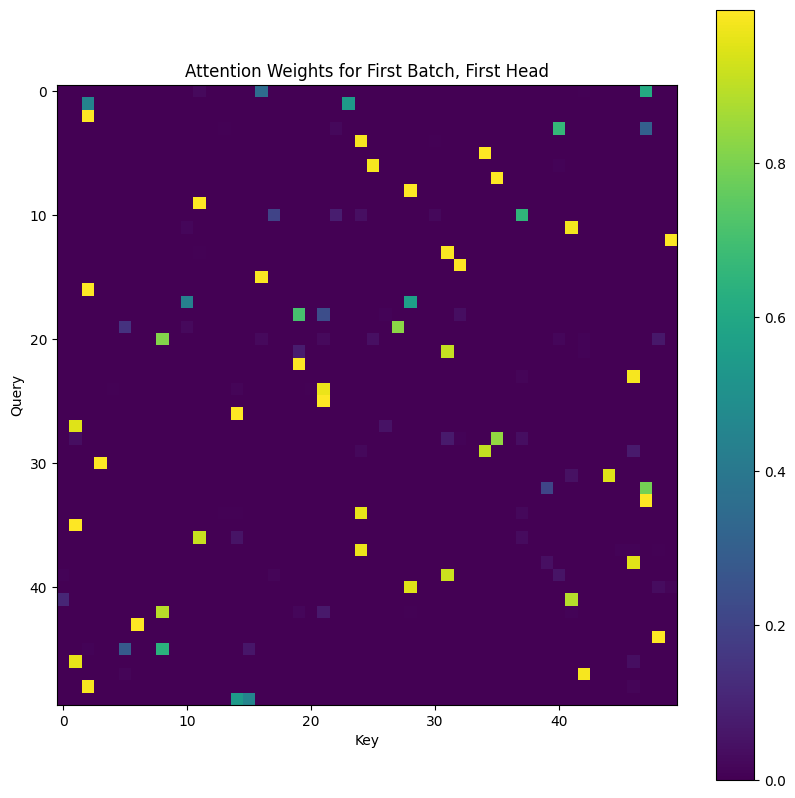

In [12]:
import matplotlib.pyplot as plt

# 打印未缩放的注意力分数
print("未缩放的注意力分数（部分）：\n", scores[0, 0, :50, :50])

# 应用 Softmax
attention_weights = F.softmax(scores, dim=-1)

# 打印 Softmax 后的注意力权重
print("Softmax 后的注意力权重（部分）：\n", attention_weights[0, 0, :50, :50])

# 可视化第一个批次、第一个注意力头的注意力权重
plt.figure(figsize=(10, 10))
plt.imshow(attention_weights[0, 0].detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title("Attention Weights for First Batch, First Head")
plt.xlabel("Key")
plt.ylabel("Query")
plt.show()

---

让我们看看加入了缩放的结果

In [13]:
import torch
import torch.nn.functional as F

# 假设输入维度d_model较大
d_model = 2048
seq_len = 50
batch_size = 32
num_heads = 16
head_dim = d_model // num_heads # 128

# 随机生成 Q 和 K
Q = torch.randn(batch_size, num_heads, seq_len, head_dim)  # (32, 8, 50, 128)
K = torch.randn(batch_size, num_heads, seq_len, head_dim)  # (32, 8, 50, 128)
print(Q.shape, K.shape)

scores = torch.matmul(Q, K.transpose(-2, -1))  # (32, 8, 50, 50)
scores = scores / torch.sqrt(torch.tensor(head_dim, dtype=torch.float32))

print(scores.shape)




torch.Size([32, 16, 50, 128]) torch.Size([32, 16, 50, 128])
torch.Size([32, 16, 50, 50])


缩放的注意力分数（部分）：
 tensor([[-0.1193, -0.3991,  1.0395,  ...,  0.6206, -0.3299,  0.3740],
        [ 1.3683,  1.5217,  0.6569,  ..., -0.4973,  1.7000, -0.7161],
        [ 0.4921,  0.4548,  0.4633,  ..., -1.2318,  1.8076,  0.6655],
        ...,
        [-1.5717, -0.9738, -0.6003,  ..., -1.2817, -0.0924,  0.8348],
        [ 1.5615,  0.3240,  0.6521,  ...,  1.4109, -0.3574, -0.0793],
        [ 2.0136, -0.1115,  1.2173,  ...,  1.8311, -1.9042, -0.5721]])
Softmax 后的注意力权重（部分）：
 tensor([[0.0095, 0.0071, 0.0301,  ..., 0.0198, 0.0077, 0.0155],
        [0.0373, 0.0434, 0.0183,  ..., 0.0058, 0.0519, 0.0046],
        [0.0176, 0.0169, 0.0171,  ..., 0.0031, 0.0655, 0.0209],
        ...,
        [0.0033, 0.0061, 0.0088,  ..., 0.0045, 0.0146, 0.0370],
        [0.0482, 0.0140, 0.0194,  ..., 0.0415, 0.0071, 0.0093],
        [0.1027, 0.0123, 0.0463,  ..., 0.0855, 0.0020, 0.0077]])


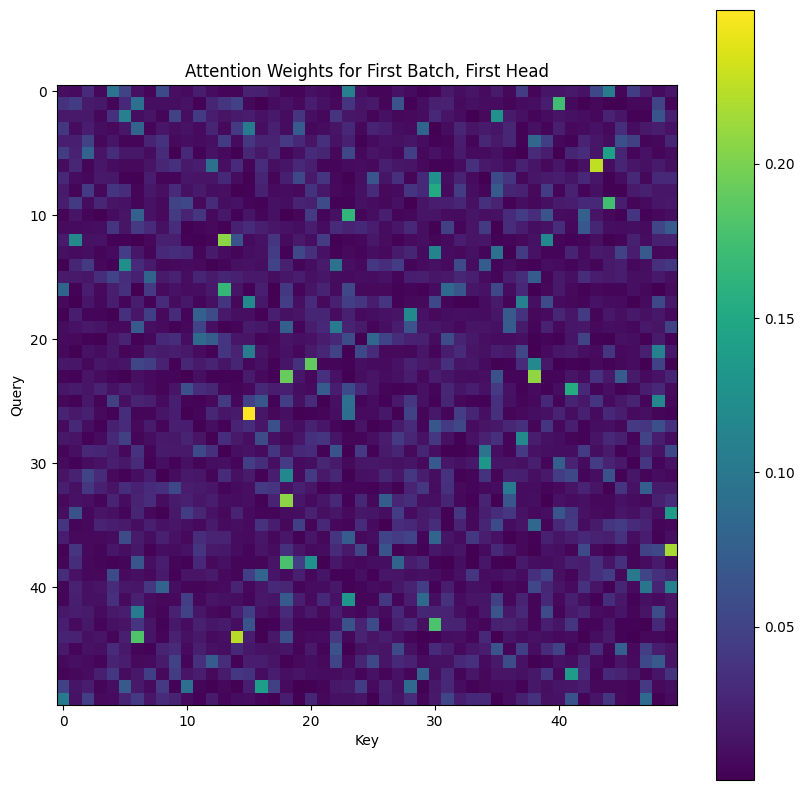

In [14]:
import matplotlib.pyplot as plt

# 打印缩放的注意力分数
print("缩放的注意力分数（部分）：\n", scores[0, 0, :50, :50])

# 应用 Softmax
attention_weights = F.softmax(scores, dim=-1)

# 打印 Softmax 后的注意力权重
print("Softmax 后的注意力权重（部分）：\n", attention_weights[0, 0, :50, :50])

# 可视化第一个批次、第一个注意力头的注意力权重
plt.figure(figsize=(10, 10))
plt.imshow(attention_weights[0, 0].detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title("Attention Weights for First Batch, First Head")
plt.xlabel("Key")
plt.ylabel("Query")
plt.show()

肉眼可见地，加入sqrt之后的attention weight分布更加平滑了，不像前者的图像，某些权重要么特别亮要么接近为0。这一点也不健康。


##### **3. Softmax**


In [15]:
import torch.nn.functional as F

attention = F.softmax(scores, dim=-1)  # (batch_size, num_heads, seq_len, seq_len)
print("注意力权重 attention 的形状：", attention.shape)
print("注意力权重 attention 的值：\n", attention)


注意力权重 attention 的形状： torch.Size([32, 16, 50, 50])
注意力权重 attention 的值：
 tensor([[[[0.0095, 0.0071, 0.0301,  ..., 0.0198, 0.0077, 0.0155],
          [0.0373, 0.0434, 0.0183,  ..., 0.0058, 0.0519, 0.0046],
          [0.0176, 0.0169, 0.0171,  ..., 0.0031, 0.0655, 0.0209],
          ...,
          [0.0033, 0.0061, 0.0088,  ..., 0.0045, 0.0146, 0.0370],
          [0.0482, 0.0140, 0.0194,  ..., 0.0415, 0.0071, 0.0093],
          [0.1027, 0.0123, 0.0463,  ..., 0.0855, 0.0020, 0.0077]],

         [[0.0313, 0.0092, 0.0049,  ..., 0.0078, 0.0305, 0.0146],
          [0.0048, 0.0753, 0.0276,  ..., 0.0234, 0.0195, 0.0084],
          [0.0103, 0.0117, 0.0089,  ..., 0.0168, 0.0129, 0.0097],
          ...,
          [0.0296, 0.0692, 0.0097,  ..., 0.0206, 0.0220, 0.0132],
          [0.0220, 0.0283, 0.0066,  ..., 0.0108, 0.0894, 0.0013],
          [0.0098, 0.0916, 0.0207,  ..., 0.0103, 0.0158, 0.0085]],

         [[0.0296, 0.0080, 0.0059,  ..., 0.0114, 0.0198, 0.0051],
          [0.0235, 0.0030, 0.0040,  .

- **解释**：
  - 对最后一个维度（`seq_len`）进行softmax，得到归一化的注意力权重。
  - 注意力权重的形状为`(batch_size, num_heads, seq_len, seq_len)`。

**注意力权重用于衡量输入序列中每个位置对其他位置的重要性，并指导模型如何聚合信息。**

---

```


#### 2.1.4 加权求和 🐱 使用注意力权重对 V 进行加权求和

与 `V` 进行加权求和是为了根据注意力权重动态提取与当前查询最相关的信息，增强模型的上下文感知能力和特征提取能力。

In [16]:
V.shape, attention.shape

(torch.Size([32, 16, 50, 32]), torch.Size([32, 16, 50, 50]))

In [17]:
output = torch.matmul(attention, V)  # (batch_size, num_heads, seq_len, head_dim)
print("加权求和后的输出 output 的形状：", output.shape)
print("加权求和后的输出 output 的值：\n", output)



加权求和后的输出 output 的形状： torch.Size([32, 16, 50, 32])
加权求和后的输出 output 的值：
 tensor([[[[-1.2230e-01, -4.4290e-02, -6.7366e-02,  ..., -1.2116e-01,
            5.2628e-01,  9.5569e-01],
          [-2.1048e-01,  1.4416e-01, -1.8828e-02,  ..., -7.2201e-02,
            6.6881e-01,  8.9801e-01],
          [-8.1148e-02,  2.2151e-01, -1.0284e-02,  ...,  5.5813e-02,
            6.3798e-01,  9.4279e-01],
          ...,
          [ 2.1776e-02, -1.9294e-02, -1.7315e-01,  ..., -2.5382e-01,
            3.7755e-01,  1.0096e+00],
          [-1.2029e-01,  1.7883e-01, -8.0604e-02,  ..., -1.0929e-01,
            5.5525e-01,  1.0154e+00],
          [ 7.2097e-02,  7.0224e-02, -1.8325e-01,  ..., -1.8521e-01,
            5.8036e-01,  9.4113e-01]],

         [[ 1.4697e-01,  4.1431e-01, -1.8531e-02,  ...,  4.4623e-01,
           -2.9548e-02, -8.0245e-02],
          [ 4.3757e-01,  5.8278e-01, -1.5764e-01,  ...,  2.9908e-01,
           -8.0500e-02, -2.3957e-01],
          [ 2.3654e-01,  5.9856e-01,  7.9787e-03,  ..., 

---

#### 2.1.5 拼接多头 🐱 将多个注意力头的输出拼接回原始维度


**1. 拼接多头的作用**
- **恢复原始维度**：
  - 在分割多头时，我们将`d_model`拆分为`num_heads * head_dim`。
  - 拼接多头的作用是将多个注意力头的输出拼接回`d_model`维度。
- **生成最终输出**：
  - 拼接后的输出形状为`(batch_size, seq_len, d_model)`，可以直接用于后续的计算。




In [18]:
# output 是加权求和的结果，形状为 (batch_size, num_heads, seq_len, head_dim)
batch_size, num_heads, seq_len, head_dim = output.shape
print("output 的形状：", output.shape)

output 的形状： torch.Size([32, 16, 50, 32])


In [19]:
# 1. 转置：将 num_heads 维度移到后面
output = output.transpose(1, 2)  # (batch_size, seq_len, num_heads, head_dim)
print("转置后的 output 的形状：", output.shape)

# 2. 拼接：将 num_heads 和 head_dim 合并为 d_model
output = output.reshape(batch_size, seq_len, -1)  # (batch_size, seq_len, d_model)

print("拼接后的 output 的形状：", output.shape)


转置后的 output 的形状： torch.Size([32, 50, 16, 32])
拼接后的 output 的形状： torch.Size([32, 50, 512])


---

#### 2.1.6 线性变换 🐱 将拼接后的输出映射回原始维度

这部分用于将之前获得的拼接结果用线性变换层映射到另外一个特征空间。这也可以用于适应下一部分``Feed-Forward Network``的输入维度。




In [20]:
import torch.nn as nn

# 定义线性变换层
# 我们原来设置的d_model是512
d_model = 512
output_projection = nn.Linear(d_model, d_model)

# 线性变换
projected_output = output_projection(output)  # (batch_size, seq_len, d_model)

print("线性变换后的 output 的形状：", projected_output.shape)


线性变换后的 output 的形状： torch.Size([32, 50, 512])


---

### 2.2 Feed-Forward Network 🐱 前馈神经网络


- **特征转换**：
  - 将多头注意力机制的输出进一步映射到更高维的特征空间。
  - 通过非线性激活函数（如ReLU）引入非线性变换。
- **独立处理**：
  - 对序列中的每个位置独立处理，不依赖其他位置的信息。
- **增强表达能力**：
  - 通过多层全连接网络增强模型的表达能力。

前馈神经网络通常由两层全连接层组成：
1. **第一层**：
   - 输入维度：`d_model`
   - 输出维度：`d_ff`（通常为`4 * d_model`）
   - 激活函数：ReLU
2. **第二层**：
   - 输入维度：`d_ff`
   - 输出维度：`d_model`
   - 无激活函数

当然了你可以随意设置层数和神经元数量，在此我只是示范而已。

很像autoencoder的结构不是吗🐱

In [21]:
import torch.nn as nn

class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForwardNetwork, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)  # 第一层全连接
        self.linear2 = nn.Linear(d_ff, d_model)  # 第二层全连接
        self.activation = nn.ReLU()  # 激活函数

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        x = self.linear1(x)  # (batch_size, seq_len, d_ff)
        x = self.activation(x)  # 非线性变换
        x = self.linear2(x)  # (batch_size, seq_len, d_model)
        return x

In [22]:

d_ff = 2048  # 通常为 4 * d_model

# 我们已经获得了projected_output，形状为 (batch_size, seq_len, d_model)
print("projected_output 的形状：", projected_output.shape)
# 前馈神经网络
ffn = FeedForwardNetwork(d_model, d_ff)
ffn_output = ffn(projected_output)

print("ffn_output 的形状：", ffn_output.shape)


projected_output 的形状： torch.Size([32, 50, 512])
ffn_output 的形状： torch.Size([32, 50, 512])


---

### 2.3 Residual Connection & Layer Normalization 🐱 残差连接和层归一化

---

#### 2.3.1 为什么要进行残差连接？
也许你已经注意到，前馈神经网络的输出`ffn_output 的形状： torch.Size([32, 50, 512])`与预处理之后的数据`x = preprocessor(input_ids)`、多头注意力的输出`拼接后的 output 的形状： torch.Size([32, 50, 512])`的形状一致。这让我们想到也许能够将其进行相加之类的操作。

**（1）保留原始信息**
- 多头注意力机制已经捕捉了序列中元素之间的关系。
- 残差连接确保这些信息不会被前馈神经网络完全覆盖，保留原始特征。

**（2）缓解梯度消失**
- 深层网络中，梯度在反向传播时容易消失。
- 残差连接提供了一条“捷径”，使梯度可以直接传播到浅层，缓解梯度消失问题。

**（3）增强模型表达能力**
- 前馈神经网络引入了非线性变换，增强了模型的表达能力。
- 残差连接将这种非线性变换与原始特征结合，进一步提升模型性能。

**（4）加速训练**
- 残差连接使模型更容易优化，加速训练过程。



In [23]:
norm1 = nn.LayerNorm(d_model)

x = norm1(x + projected_output)

print("残差连接和层归一化后的 x 的形状：", x.shape)


残差连接和层归一化后的 x 的形状： torch.Size([32, 50, 512])



在此之后，这个`x`再经过我们之前提到过的`Feed-Forward`得到的`ffn_output = ffn(projected_output)`进行残差链接，最后将`x`进行层归一化。


In [24]:
norm2 = nn.LayerNorm(d_model)

x = norm2(x + ffn_output)

print("残差连接和层归一化后的 x 的形状：", x.shape)



残差连接和层归一化后的 x 的形状： torch.Size([32, 50, 512])


---
#### 2.3.2 为什么要层归一化？



层归一化（Layer Normalization）是一种用于神经网络中的归一化技术，主要用于加速训练过程并提高模型的稳定性。以下是详细解释：

**. 层归一化的作用**
- **归一化特征**：
  - 对每个样本的特征进行归一化，使其均值为0，方差为1。
  - 减少内部协变量偏移（Internal Covariate Shift），使训练更稳定。
- **加速收敛**：
  - 归一化后的特征分布更稳定，有助于加速模型收敛。
- **适用于不同任务**：
  - 特别适合处理变长序列（如NLP任务）和小批量数据。

**. 层归一化的公式**
层归一化的计算公式如下：
```python
y = (x - mean) / sqrt(var + eps) * gamma + beta
```
- **`x`**：输入特征。
- **`mean`**：输入特征的均值。
- **`var`**：输入特征的方差。
- **`eps`**：一个小常数，用于数值稳定性（默认`1e-5`）。
- **`gamma`**：可学习的缩放参数（权重）。
- **`beta`**：可学习的偏移参数（偏置）。

---

**. 层归一化的特点**
- **独立于批量大小**：
  - 与批量归一化（Batch Normalization）不同，层归一化不依赖于批量大小，适合处理小批量或变长序列。
- **逐样本归一化**：
  - 对每个样本的特征进行归一化，而不是跨样本归一化。
- **可学习的参数**：
  - `gamma` 和 `beta` 是可学习的参数，允许模型调整归一化后的特征分布。



以上就是`Encoder`中一个`EncoderLayer`的全部内容，为了获取`Encoder`，我们需要将`EncoderLayer`堆叠起来。你可以在`transformer_encoder.py`中找到完整的代码。

---

## 3. Decoder 🐱 解码器

---
### 3.1. **掩码多头自注意力**：
   - 捕捉已生成序列的内部关系。


---
#### 3.1.1 为什么就需要掩码了？之前的Encoder中的注意力不需要掩码呢？

---

##### 1. **任务性质不同**
- **Encoder**：
  - 处理的是完整的输入序列（如源语言句子）
  - 需要同时看到整个序列的所有信息
  - 目标是捕捉序列中所有元素之间的关系

- **Decoder**：
  - 处理的是目标序列（如目标语言句子）
  - 需要逐步生成序列，不能"偷看"未来信息
  - 目标是基于已生成的部分序列和Encoder的输出来预测下一个元素



---

##### 2. **掩码的作用**
- **防止信息泄露**：
  - 在训练时，Decoder会接收完整的目标序列
  - 如果没有掩码，模型可能会直接"看到"未来的信息，导致训练作弊
  - 掩码确保模型只能使用当前位置及之前的信息

- **保持自回归性质**：
  - 在推理时，Decoder需要逐个生成序列元素
  - 掩码确保模型只能基于已生成的部分序列进行预测
  - 这是序列生成任务（如机器翻译、文本生成）的基本要求



---

##### 3. **具体实现**
- **Encoder中的注意力**：
  - 计算注意力分数时，所有位置之间都可以相互关注
  - 不需要任何限制，因为整个输入序列是已知的

- **Decoder中的掩码注意力**：
  - 使用下三角掩码（`torch.tril`）
  - 确保每个位置只能关注到它自身及之前的位置
  - 未来位置的注意力分数被设置为`-inf`，在softmax后权重为0


Q 的形状： torch.Size([32, 16, 50, 32])
K 的形状： torch.Size([32, 16, 50, 32])
Encoder注意力分数 scores 的形状： torch.Size([32, 16, 50, 50])


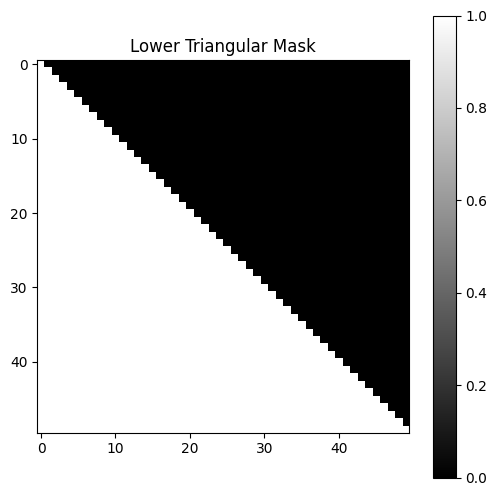

mask 的形状： torch.Size([50, 50])
mask 的值： tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
Decoder注意力分数 scores 的形状： torch.Size([32, 16, 50, 50])
mask 的形状： torch.Size([50, 50])
mask 的值： tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.]])


In [25]:
import torch
from math import sqrt

Q = torch.randn(32, 16, 50 ,32)
K = torch.randn(32, 16, 50 ,32)

print("Q 的形状：", Q.shape)
print("K 的形状：", K.shape)

# Encoder注意力分数（无掩码）
scores = torch.matmul(Q, K.transpose(-2, -1)) / sqrt(head_dim)
# print("Encoder注意力分数 scores：", scores)
print("Encoder注意力分数 scores 的形状：", scores.shape)


# Decoder注意力分数（带掩码）
scores = torch.matmul(Q, K.transpose(-2, -1)) / sqrt(head_dim)
# 生成下三角掩码
seq_len = 50  # 序列长度为50
mask = torch.tril(torch.ones(seq_len, seq_len))  # 下三角掩码

# 可视化掩码
plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
plt.title("Lower Triangular Mask")
plt.colorbar()
plt.show()

# 打印掩码的形状和值
print("mask 的形状：", mask.shape)
print("mask 的值：", mask)
scores = scores.masked_fill(mask == 0, float('-inf'))  # 应用掩码
# print("Decoder注意力分数 scores：", scores)
print("Decoder注意力分数 scores 的形状：", scores.shape)
print("mask 的形状：", mask.shape)
print("mask 的值：", mask)

---

#### 3.1.2 为什么需要下三角掩码？

---

##### 1. **自回归任务的性质**
在自回归任务中，模型需要**逐步生成序列**，即每次只能基于已经生成的部分序列来预测下一个元素。例如：
- 在文本生成中，模型只能基于已经生成的单词来预测下一个单词。
- 在机器翻译中，模型只能基于已经生成的目标语言单词来预测下一个单词。

如果模型能够“看到”未来的信息，它就会作弊，直接使用未来的信息来预测当前的位置，这会导致训练和推理不一致。

---

##### 2. **下三角掩码的作用**
下三角掩码的作用是**限制模型只能访问当前位置及之前的信息**，而不能访问未来的信息。具体来说：
- **下三角部分**：值为1，表示允许模型访问这些位置的信息。
- **上三角部分**：值为0，表示禁止模型访问这些位置的信息。

通过将上三角部分的注意力分数设置为`-inf`，在softmax操作后，这些位置的权重会变为0，从而确保模型无法利用未来的信息。

---

##### 3. **掩码的实现**
在代码中，下三角掩码通常通过`torch.tril`函数生成：
````python
mask = torch.tril(torch.ones(seq_len, seq_len))
````
例如，对于一个长度为5的序列，掩码矩阵如下：
````
1 0 0 0 0
1 1 0 0 0
1 1 1 0 0
1 1 1 1 0
1 1 1 1 1
````
- 第1行：只能看到第1个位置。
- 第2行：可以看到第1和第2个位置。
- 第3行：可以看到第1、第2和第3个位置。
- 以此类推。

---

##### 4. **为什么需要下三角掩码？**
###### （1）**训练时防止信息泄露**
- 在训练时，Decoder会接收完整的目标序列（如目标语言句子）。
- 如果没有掩码，模型可能会直接“看到”未来的信息，导致训练作弊。
- 掩码确保模型只能使用当前位置及之前的信息。

###### （2）**推理时保持自回归性质**
- 在推理时，Decoder需要逐个生成序列元素。
- 掩码确保模型只能基于已生成的部分序列进行预测。
- 这是序列生成任务（如机器翻译、文本生成）的基本要求。

###### （3）**确保训练和推理一致性**
- 训练时使用掩码，推理时也使用掩码，确保模型的行为一致。
- 如果训练时不使用掩码，模型可能会学习到依赖未来信息的错误模式，导致推理时性能下降。

---

##### 5. **示例**
假设我们有一个长度为3的序列，计算注意力分数时：
- **无掩码**：模型可以看到所有位置的信息。
  ````
  scores = [[s11, s12, s13],
            [s21, s22, s23],
            [s31, s32, s33]]
  ````
- **有掩码**：模型只能看到当前位置及之前的信息。
  ````
  scores = [[s11, -inf, -inf],
            [s21, s22, -inf],
            [s31, s32, s33]]
  ````
在softmax后，`-inf`的位置权重为0，模型无法利用这些信息。




##### 6. **总结**
| 特性                | 无掩码                  | 下三角掩码              |
|---------------------|------------------------|------------------------|
| 信息访问            | 可以访问整个序列        | 只能访问当前位置及之前  |
| 训练时              | 可能作弊，利用未来信息  | 防止信息泄露            |
| 推理时              | 无法逐步生成序列        | 保持自回归性质          |
| 适用场景            | Encoder                | Decoder                |


#### 3.1.3 输入是什么？

1. tgt: 目标序列的嵌入表示。也就是我们之前通过TransformerPreprocessor得到的被预处理的输入。
2. tgt_mask: 下三角掩码，用于限制模型只能访问当前位置及之前的信息。
3. memory: Encoder的输出，用于计算Encoder-Decoder Attention。


---

## 4. Output Layer 🐱 输出层

在《Attention is All You Need》论文中，输出层的主要意义是将解码器的输出转换为最终的预测结果。具体来说，输出层的作用包括：

1. **线性变换**：将解码器的输出（通常是高维向量，在我们的例子中`输出: torch.Size([32, 50, 512])`）映射到词汇表大小的维度。这一步通过一个线性层（`nn.Linear`）实现，生成每个位置每个词的概率分数（logits）。

2. **生成概率分布**：通过 Softmax 函数将 logits 转换为概率分布。这个概率分布表示每个位置每个词的概率，模型可以根据这个分布选择最可能的词作为输出。

3. **序列生成**：在序列生成任务（如机器翻译、文本生成等）中，输出层的概率分布用于生成最终的序列。通常，模型会选择概率最高的词作为下一个词，逐步生成整个序列。

总结来说，输出层的作用是将解码器的抽象表示转换为具体的词汇概率分布，从而生成最终的预测结果。这是 Transformer 模型完成序列生成任务的关键步骤。

In [26]:
class OutputLayer(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(OutputLayer, self).__init__()
        # 线性层，将 d_model 维映射到词汇表大小
        self.linear = nn.Linear(d_model, vocab_size) # 别忘了我们设置d_model为512，vocab_size为10000
        # Softmax 函数，用于生成概率分布
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # 线性变换，输出形状: [batch_size, seq_len, vocab_size]
        logits = self.linear(x)
        # Softmax 生成概率分布
        probs = self.softmax(logits)
        return logits, probs
    

# 初始化输出层
output_layer = OutputLayer(d_model=512, vocab_size=vocab_size)

# 解码器的输出，形状为 [32, 50, 512]
decoder_output = torch.randn(32, 50, 512)

# 前向传播
logits, probs = output_layer(decoder_output)

# 检查输出形状
print("Logits 形状:", logits.shape)  # 输出: torch.Size([32, 50, 10000])
print("概率分布形状:", probs.shape)  # 输出: torch.Size([32, 50, 10000])

Logits 形状: torch.Size([32, 50, 10000])
概率分布形状: torch.Size([32, 50, 10000])



- **`logits` 形状 `[32, 50, 10000]`**：
  - `32` 是批次大小（batch size），表示同时处理 32 个样本。
  - `50` 是序列长度（sequence length），表示每个样本有 50 个时间步或位置。
  - `10000` 是词汇表大小（vocab size），表示每个位置有 10000 个可能的词。

- **`probs` 形状 `[32, 50, 10000]`**：
  - 这是 `logits` 经过 Softmax 后的概率分布，形状与 `logits` 相同。
  - 每个位置的概率分布总和为 1，表示模型对每个位置预测的词的概率。

### 为什么是这种形状？
- 这种形状符合 Transformer 的输出设计，适用于序列生成任务（如机器翻译、文本生成等）。
- 每个位置的概率分布可以用于选择最可能的词，逐步生成输出序列。
